In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Imputer
from os import listdir
from os.path import isfile, join
%matplotlib inline

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 3 Basic Prediction Model

### 3.1 Load Dataframes and cursory cleaning

In [2]:
# Census data path
census_data_path = 'Crime/data/census/'

In [3]:
census_folder_fps = [f for f in listdir(census_data_path) if isfile(join(census_data_path, f))]

In [4]:
csv_filepaths = [f for f in listdir('csvs/') if isfile(join('csvs/', f))]

In [5]:
census_filepaths = [f for f in census_folder_fps if f[3:] == 'census.csv']

In [6]:
# Function that strips dashes, helper for merge_df_msa
def strip_dashes(x):
    return ' '.join(' '.join(x.split('-')).split())

In [7]:
# Function to merge FBI data and census data
def merge_df_msa(fbi_df, census_df):
    census_mask = census_df['Geography'].isnull()
    fbi_mask = fbi_df['Metropolitan_Statistical_Area'].isnull()
    
    df_c = census_df[~census_mask]
    df_f = fbi_df[~fbi_mask]
    
    geos = df_c['Geography'].apply(lambda x: x.split('Metro Area')[0].strip())
    geos = geos.apply(strip_dashes)
    df_c['Geography'] = geos
    
    fbi_geos = df_f['Metropolitan_Statistical_Area'].apply(strip_dashes)
    df_f['Metropolitan_Statistical_Area'] = fbi_geos
    
    return pd.merge(df_f, df_c, left_on='Metropolitan_Statistical_Area', right_on='Geography', how='inner').drop('Geography', axis=1)
    

In [8]:
# Load all dataframes into a dict
df_dict = dict()
for i in range(0, 11):
    df_fbi = pd.read_csv(join('csvs/', csv_filepaths[i]))
    df_census = pd.read_csv(join(census_data_path, census_filepaths[i]), skiprows=1).drop(['Id', 'Id2'], axis=1)
    columns = [col for col in df_census.columns if 'Native' not in col and 'Margin of Error' not in col]
    foreign = [x for x in df_census.columns if 'born outside' in x][0]
    non_native = df_census[foreign]
    
    df_census = df_census[columns]
    df_census['non_native'] = non_native
    
    df = merge_df_msa(df_fbi, df_census)
    
    # Compute murders per 100,000 people
    population = [x for x in df.columns if 'Total population' in x][0]
    per_100 = pd.to_numeric(df[population], errors='coerce')/100000.0
    df['Murders_per_100000'] = df['Murder_and_nonnegligent_manslaughter']/per_100
    df['population'] = df[population]
    
    # Drop any columns that don't have murder counts
    df = df.dropna(subset=['Murders_per_100000'])
    
    df_dict[i + 6] = df

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Combine all dataframes into 1 big dataframe
frames = []
for k, v in df_dict.items():
    
    # Various labels we decided would be relevant, basic demographic
    male = [x for x in v.columns if 'Male' in x][0]
    median_age = [x for x in v.columns if 'Median age' in x][0]
    median_income = [x for x in v.columns if 'Median income' in x][-1]
    black = [x for x in v.columns if 'Black or' in x][0]
    white = [x for x in v.columns if 'White' in x][0]
    hispanic = [x for x in v.columns if 'Hispanic' in x][0]
    poverty = [x for x in v.columns if 'poverty' in x][1]
    
    # Income Labels
    income_levels = [x for x in v.columns if 'Population 15 years and over - $' in x]
    income_labels = [x.split("- ")[-1] for x in v.columns if 'Population 15 years and over - $' in x]
    for i, level in enumerate(income_levels):
        v[income_labels[i]] = v[income_levels[i]]
        
    # Education Levels
    uneducated = [x for x in v.columns if 'EDUCATIONAL ATTAINMENT' in x][1]
    highschool = [x for x in v.columns if 'EDUCATIONAL ATTAINMENT' in x][2]
    college = [x for x in v.columns if 'EDUCATIONAL ATTAINMENT' in x][3:5]
    
    v["Year"] = 2000 + k
    non_native_series = pd.to_numeric(v['non_native'], errors='coerce').fillna(0)
    pop_series = pd.to_numeric(v['Total; Estimate; Total population'], errors='coerce').fillna(1)
    cols = ['Murder_and_nonnegligent_manslaughter', 'Murders_per_100000', 'Year', poverty, male,
            median_age, median_income, black, white, hispanic, uneducated, highschool] + income_levels
    df_temp = v[cols]
    column_labels = ['murder_count', 'murder_per_100000', 'year', 'poverty', 'male','median_age', 
                       'median_income', 'black', 'white', 'hispanic', 'uneducated', 'highschool'] + income_labels
    
    # Percentage of population that are young adults, could include or not!
    ya_tier = [x for x in v.columns if 'AGE' in x][:8][2]
    ya_series = pd.to_numeric(v[ya_tier], errors='coerce').fillna(0)
    ya_percentage = ya_series/pop_series
    
    df_temp.columns = column_labels
    df_temp['college'] = v[college].sum(axis=1)
    df_temp['foreign'] = non_native_series / pop_series
    df_temp['population'] = v['population']
    frames.append(df_temp)
df_concat = pd.concat(frames)

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [10]:
# Split data into training and test sets
y = df_concat['murder_per_100000']
X = df_concat.drop(['murder_per_100000', 'murder_count'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Linear Ridge, Lasso, KNN regression CV on basic columns (sex, income, etc...)

#### 3.2.1 Set up training and validation datasets

In [11]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
# Function to train and validate on given columns
def train_and_validate(X_tr, X_val, y_tr, y_val, cols, title, add_const=True, poly=False, include_knn=True):
    X_col_tr = X_tr[cols].apply(pd.to_numeric, errors='coerce').values
    X_col_val = X_val[cols].apply(pd.to_numeric, errors='coerce').values
    imputer = Imputer(strategy='mean')
    
    # Fill nan values with means
    X_col_tr = imputer.fit_transform(X_col_tr)
    X_col_val = imputer.fit_transform(X_col_val)

    # Scale everything
    scaler = MinMaxScaler()
    if poly:
        poly_generator = PolynomialFeatures(4, include_bias=False)
        if add_const:
            X_col_tr = poly_generator.fit_transform(scaler.fit_transform(X_col_tr))
            X_col_val = poly_generator.fit_transform(scaler.fit_transform(X_col_val))
        else:
            X_col_tr = sm.add_constant(poly_generator.fit_transform(scaler.fit_transform(X_tr_col)))
            X_col_val = sm.add_constant(poly_generator.fit_transform(scaler.fit_transform(X_val_col)))
    else:
        if add_const:
            X_col_tr = sm.add_constant(scaler.fit_transform(X_col_tr))
            X_col_val = sm.add_constant(scaler.fit_transform(X_col_val))
        else:
            X_col_tr = scaler.fit_transform(X_col_tr)
            X_col_val = scaler.fit_transform(X_col_val)
            
            
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_col_tr, y_tr)
    print('Training R^2 for {} Linear Regression: {}'.format(title, lr.score(X_col_tr, y_tr)))
    print('Validation R^2 for {} Linear Regression: {}'.format(title, lr.score(X_col_val, y_val)))
    print()

    # Lasso Regression
    lasso = LassoCV(cv=5)
    lasso.fit(X_col_tr, y_tr)
    print('Training R^2 for {} Lasso Regression: {}'.format(title, lasso.score(X_col_tr, y_tr)))
    print('Validation R^2 for {} Lasso Regression: {}'.format(title, lasso.score(X_col_val, y_val)))
    print()

    # Ridge Regression
    ridge = RidgeCV(cv=5)
    ridge.fit(X_col_tr, y_tr)
    print('Training R^2 for {} Ridge Regression: {}'.format(title, ridge.score(X_col_tr, y_tr)))
    print('Validation R^2 for {} Ridge Regression: {}'.format(title, ridge.score(X_col_val, y_val)))
    print()

    # KNN, with max_neighbors found through CV
    if include_knn:
        ks = list(range(2, 50))
        scores = []
        scores_val = []
        max_score = 0
        max_k = 0 
        for k in ks:
            knn = KNeighborsRegressor(n_neighbors = k)
            score = cross_val_score(knn, X_col_tr, y_tr).mean()
            scores.append(score)
            scores_val.append(cross_val_score(knn, X_col_val, y_val).mean())
            if score > max_score:
                max_k = k
                max_score = score
        knn = KNeighborsRegressor(n_neighbors = max_k)
        knn.fit(X_col_tr, y_tr)
        print("Training Score for KNN (k={}) Model: {}".format(max_k, knn.score(X_col_tr, y_tr)))
        print("Validation Score for KNN (k={}) Model: {}".format(max_k, knn.score(X_col_val, y_val)))
        
        plt.figure(figsize=(10,10))
        plt.plot(ks, scores, color='darkorange', lw=2, label='Train CV Scores')
        plt.plot(ks, scores_val, color='blue', lw=2, label='Validation CV Scores')
        plt.axvline(x=max_k, color='red', label='best k = {}'.format(max_k), linestyle='--')
        plt.xlabel('k from K-Neighbors model')
        plt.ylabel('CV Score')
        plt.title('Train, Validation, and Test CV Scores for KNN')
        plt.legend(loc="lower right")
    else:
        knn=False
    
    return [lr, lasso, ridge, knn]

Training R^2 for Basic Linear Regression: 0.10336462166830496
Validation R^2 for Basic Linear Regression: 0.0905740112706801

Training R^2 for Basic Lasso Regression: 0.10196365776150063
Validation R^2 for Basic Lasso Regression: 0.08412300206289403

Training R^2 for Basic Ridge Regression: 0.1031256353613198
Validation R^2 for Basic Ridge Regression: 0.09070882715172046

Training Score for KNN (k=13) Model: 0.384829110871148
Validation Score for KNN (k=13) Model: 0.02369172929875007


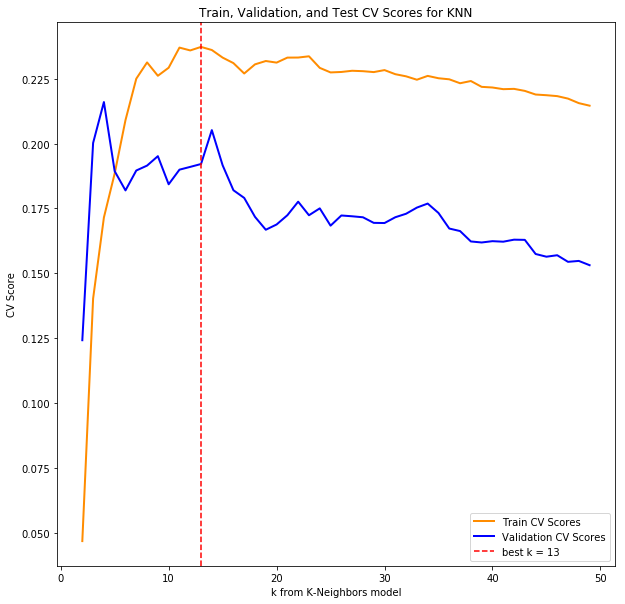

In [13]:
basic_cols = ['median_age', 'median_income', 'male', 'poverty', 'population']
basic_models = train_and_validate(X_tr, X_val, y_tr, y_val, basic_cols, "Basic", add_const=True, poly=False)

### 3.3 Include more comprehensive income levels in each model

Training R^2 for Income Linear Regression: 0.14258477634600875
Validation R^2 for Income Linear Regression: 0.1448900418121657

Training R^2 for Income Lasso Regression: 0.1418296759572274
Validation R^2 for Income Lasso Regression: 0.14534604419731512

Training R^2 for Income Ridge Regression: 0.14155031635922333
Validation R^2 for Income Ridge Regression: 0.14566808055357683

Training Score for KNN (k=10) Model: 0.39124066387943257
Validation Score for KNN (k=10) Model: 0.1320391142119982


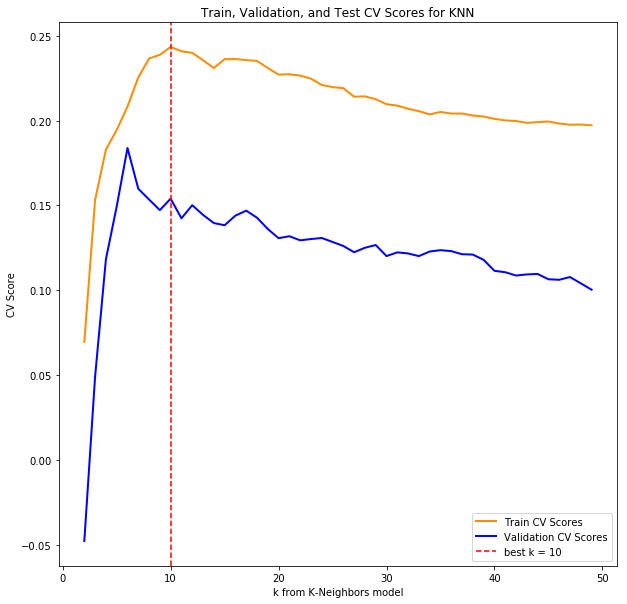

In [14]:
income_cols = basic_cols + ['$1 to $9,999 or loss', '$10,000 to $14,999', '$15,000 to $24,999',
               '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $64,999',
               '$65,000 to $74,999', '$75,000 or more']
comp_income_models = train_and_validate(X_tr, X_val, y_tr, y_val, income_cols, "Income", add_const=True, poly=False)

Currently it looks as though Ridge Regression performs the best out of the the basic linear regression models

### 3.4 Include all columns in each model

Training R^2 for All Columns Linear Regression: 0.4462319942491597
Validation R^2 for All Columns Linear Regression: 0.4108502357189554

Training R^2 for All Columns Lasso Regression: 0.44560209039581394
Validation R^2 for All Columns Lasso Regression: 0.4102549436785793

Training R^2 for All Columns Ridge Regression: 0.4458059433121516
Validation R^2 for All Columns Ridge Regression: 0.41016795215679747

Training Score for KNN (k=18) Model: 0.5069220726159709
Validation Score for KNN (k=18) Model: 0.44440789682622034


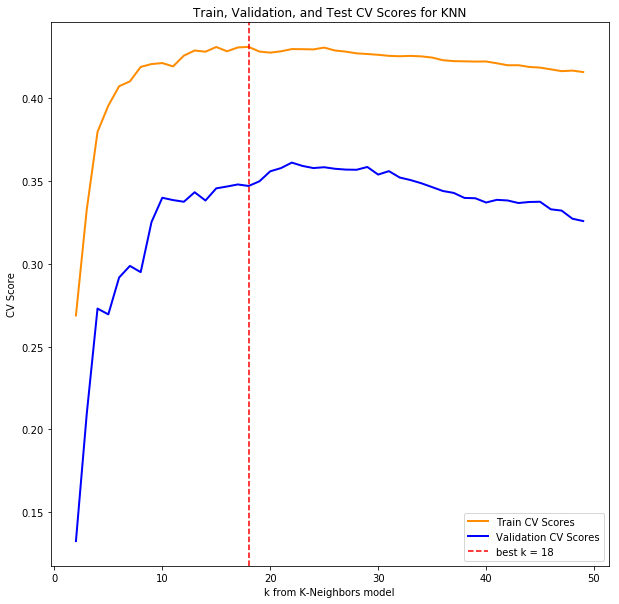

In [15]:
all_col_models = train_and_validate(X_tr, X_val, y_tr, y_val, X_tr.columns, "All Columns", add_const=True, poly=False)

### 3.5 OLS Model to determine statistically significant predictors

#### 3.5.1 OLS Model

In [16]:
X_all_train = X_tr.apply(pd.to_numeric, errors='coerce')
X_all_val = X_val.apply(pd.to_numeric, errors='coerce')

imputer = Imputer(strategy='mean')

# Fill nan values with means
X_const_train = imputer.fit_transform(X_all_train)
X_const_val = imputer.fit_transform(X_all_val)

# Scale everything and add constant
scaler = MinMaxScaler()
X_const_train = sm.add_constant(scaler.fit_transform(X_const_train))
X_const_val = sm.add_constant(scaler.fit_transform(X_const_val))

model = OLS(endog=y_tr, exog=X_const_train)
result = model.fit()

y_hat_train = result.predict()
y_hat_val = result.predict(exog=X_const_val)

print('Train R^2 =', r2_score(y_tr, y_hat_train))
print('Validation R^2 =', r2_score(y_val, y_hat_val))

Train R^2 = 0.446231994249
Validation R^2 = 0.410850235719


In [17]:
xlabs = ['const'] + list(X_train.columns)
result.summary(xname=xlabs)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      murder_per_100000   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     79.70
Date:                Wed, 06 Dec 2017   Prob (F-statistic):          5.55e-248
Time:                        20:15:43   Log-Likelihood:                -4719.9
No. Observations:                2099   AIC:                             9484.
Df Residuals:                    2077   BIC:                             9608.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.7329      1.957      2.930      0.003       1.896       9.570
$1 to $9,999 or loss     0.7105      0.793      0.896      0.370      -0.845       2.266
$10,000 to $14,999       0.5470      0.596      0.917      0.359      -0.622       1.716
$15,000 to $24,999      -0.5599      0.906     -0.618      0.537      -2.337       1.217
$25,000 to $34,999       1.1013      0.616      1.787      0.074      -0.108       2.310
$35,000 to $49,999       0.5251      0.673      0.780      0.435      -0.794       1.845
$50,000 to $64,999      -0.9803      0.726     -1.350      0.177      -2.404       0.444
$65,000 to $74,999       1.1605      0.642      1.809      0.071      -0.098       2.419
$75,000 or more          1.6142      1.042      1.549      0.122      -0.430       3.658
black                    3.7697      0.489      7.710      0.000       2.811       4.729
college                  1.6800      0.868      1.936      0.053      -0.022       3.382
foreign                 -1.7076      0.472     -3.616      0.000      -2.634      -0.782
highschool               3.2544      0.784      4.153      0.000       1.718       4.791
hispanic                 0.8060      0.597      1.349      0.177      -0.365       1.977
male                    -0.6007      0.672     -0.893      0.372      -1.919       0.718
median_age               1.7845      0.705      2.532      0.011       0.402       3.167
median_income           -1.8899      1.171     -1.614      0.107      -4.187       0.407
population               1.7170      0.820      2.094      0.036       0.109       3.325
poverty                  0.0808      0.700      0.115      0.908      -1.293       1.454
uneducated               3.2330      0.912      3.544      0.000       1.444       5.022
white                   -8.7646      0.625    -14.016      0.000      -9.991      -7.538
year                    -0.1063      0.166     -0.641      0.521      -0.431       0.219
==============================================================================
Omnibus:                      521.600   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2342.335
Skew:                           1.121   Prob(JB):                         0.00
Kurtosis:                       7.665   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
print("Significant predictors at alpha = 0.05:", list(np.array(xlabs)[np.array(result.pvalues < 0.05)]), 'with p-values of:', list(result.pvalues[np.array(result.pvalues < 0.05)]))

Significant predictors at alpha = 0.05: ['const', 'black', 'foreign', 'highschool', 'median_age', 'population', 'uneducated', 'white'] with p-values of: [0.0034255754667554413, 1.9406727072854948e-14, 0.00030586819343893327, 3.4184670079430795e-05, 0.011409139649156946, 0.036380755382960761, 0.00040328399497637418, 1.0271980794482728e-42]


In [19]:
most_significant = np.array(xlabs)[np.array(result.pvalues < 0.05)][1:]

#### 3.5.2 Train models on most significant predictors determined by OLS

Training R^2 for Most Significant OLS Predictors Linear Regression: 0.4403589258248584
Validation R^2 for Most Significant OLS Predictors Linear Regression: 0.40655554960022205

Training R^2 for Most Significant OLS Predictors Lasso Regression: 0.4403526474899125
Validation R^2 for Most Significant OLS Predictors Lasso Regression: 0.40658558175226805

Training R^2 for Most Significant OLS Predictors Ridge Regression: 0.4402215161510081
Validation R^2 for Most Significant OLS Predictors Ridge Regression: 0.406473259967734

Training Score for KNN (k=7) Model: 0.6573569971226408
Validation Score for KNN (k=7) Model: 0.4990922977081862


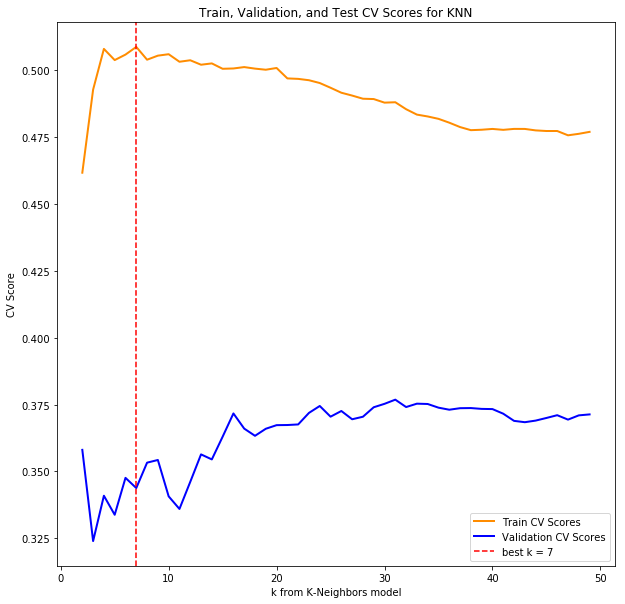

In [20]:
OLS_sig_col_models = train_and_validate(X_tr, X_val, y_tr, y_val, most_significant, "Most Significant OLS Predictors", add_const=True, poly=False)

### 3.6 Subset Selection

In [21]:
# Function to help with subset selection, supports forward and backwards subset selection
def step_forwards_backwards(df, y_vars, direction='forward'):
    assert direction in ['forward', 'backward']
    y = y_vars.reshape(-1,1)
    predictors = set(df.columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    n = df.shape[0]
    best_bic = np.inf
    best_bics = []
    best_models = []
    
    imputer = Imputer(strategy='mean')
    
    if direction == 'forward':
        X = np.ones(n).reshape(-1,1)
        X = np.concatenate([X, df[list(selected_predictors)].values], axis=1)
        while (True):
            possible_bic_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            if len(possible_predictors) == 0:
                break
            for predictor in possible_predictors:
                x_temp = np.concatenate([X, df[predictor].values.reshape(-1,1)], axis=1)
                x_temp = imputer.fit_transform(x_temp)
                
                model = OLS(endog=y, exog=x_temp).fit()
                bic = model.bic
                possible_bic_scores.append(bic)
            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            best_bic = np.min(possible_bic_scores)
            best_bics.append(best_bic)
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, df[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))
    else:
        while (True):
            possible_bic_scores = []
            possible_predictors = list(selected_predictors)
            if len(possible_predictors) == 0:
                break
            for predictor in possible_predictors:
                X = np.concatenate([np.ones(n).reshape(-1,1), df[list(selected_predictors - set([predictor]))].values], axis=1)
                X = imputer.fit_transform(X)
                
                model = OLS(endog=y, exog=X).fit()
                bic = model.bic
                possible_bic_scores.append(bic)
            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix] 
            best_bic = possible_bic_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            best_bics.append(best_bic)
            best_models.append(list(selected_predictors))
    index_of_best_bic = np.argmin(best_bics)
    return best_models[index_of_best_bic]

In [22]:
# forwards selection
predictors_forward = step_forwards_backwards(X_all_train, y_tr, direction='forward')
predictors_forward

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


['highschool', 'black', 'median_age', 'foreign', 'uneducated', 'white']

In [23]:
# backwards selection
predictors_backward = step_forwards_backwards(X_all_train, y_tr, direction='backward')
predictors_backward

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


['median_age', 'white', 'highschool', 'black', 'foreign', 'uneducated']

#### 3.6.1 Use columns from forwards and backwards selection in Ridge, Lasso, K-NN Regression

Training R^2 for Forward BIC Selection Linear Regression: 0.4395767505680862
Validation R^2 for Forward BIC Selection Linear Regression: 0.4058955039695988

Training R^2 for Forward BIC Selection Lasso Regression: 0.4395728491071222
Validation R^2 for Forward BIC Selection Lasso Regression: 0.40591249707502186

Training R^2 for Forward BIC Selection Ridge Regression: 0.4394289184448102
Validation R^2 for Forward BIC Selection Ridge Regression: 0.40572943969483877

Training Score for KNN (k=7) Model: 0.6556020765509312
Validation Score for KNN (k=7) Model: 0.49629440076890985


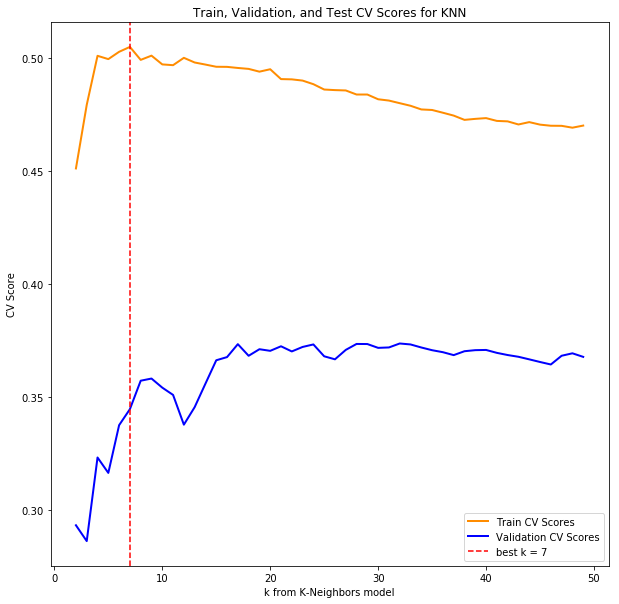

In [24]:
# Forward Selection
fwd_models = train_and_validate(X_tr, X_val, y_tr, y_val, predictors_forward, "Forward BIC Selection", add_const=True, poly=False)

Training R^2 for Backward BIC Selection Linear Regression: 0.4395767505680862
Validation R^2 for Backward BIC Selection Linear Regression: 0.4058955039695988

Training R^2 for Backward BIC Selection Lasso Regression: 0.4395729554888817
Validation R^2 for Backward BIC Selection Lasso Regression: 0.4059089097399196

Training R^2 for Backward BIC Selection Ridge Regression: 0.4394289184448102
Validation R^2 for Backward BIC Selection Ridge Regression: 0.40572943969483877

Training Score for KNN (k=7) Model: 0.6556020765509312
Validation Score for KNN (k=7) Model: 0.49629440076890985


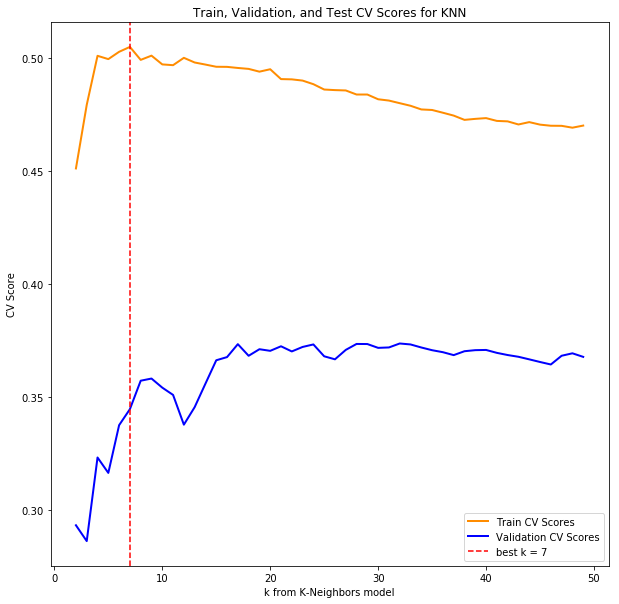

In [25]:
# Backwards Selection
back_models = train_and_validate(X_tr, X_val, y_tr, y_val, predictors_backward, "Backward BIC Selection", add_const=True, poly=False)

Training R^2 for Union of BIC Selected Columns Linear Regression: 0.4395767505680862
Validation R^2 for Union of BIC Selected Columns Linear Regression: 0.4058955039695988

Training R^2 for Union of BIC Selected Columns Lasso Regression: 0.4395728491071222
Validation R^2 for Union of BIC Selected Columns Lasso Regression: 0.40591249707502186

Training R^2 for Union of BIC Selected Columns Ridge Regression: 0.4394289184448102
Validation R^2 for Union of BIC Selected Columns Ridge Regression: 0.40572943969483877

Training Score for KNN (k=7) Model: 0.6556020765509312
Validation Score for KNN (k=7) Model: 0.49629440076890985


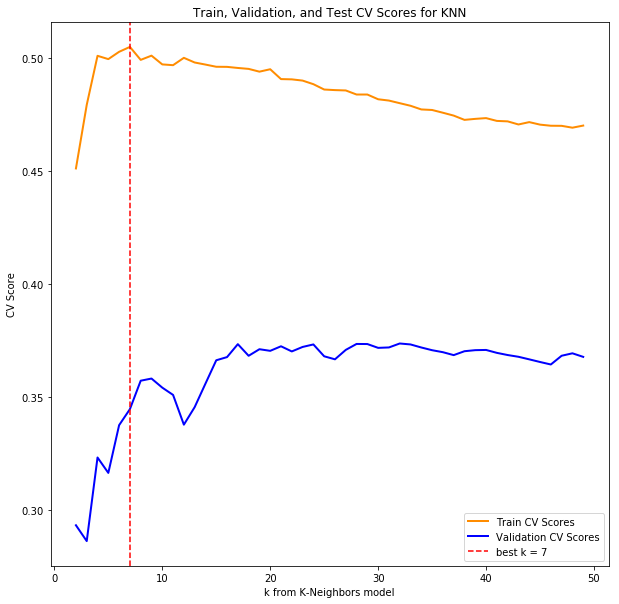

In [26]:
# Union of forward and backward selected subsets
union = list(set(predictors_forward).union(set(predictors_backward)))
union_models = train_and_validate(X_tr, X_val, y_tr, y_val, union, "Union of BIC Selected Columns", add_const=True, poly=False)

Training R^2 for Intersection of BIC Selected Columns Linear Regression: 0.4395767505680862
Validation R^2 for Intersection of BIC Selected Columns Linear Regression: 0.4058955039695988

Training R^2 for Intersection of BIC Selected Columns Lasso Regression: 0.4395728491071222
Validation R^2 for Intersection of BIC Selected Columns Lasso Regression: 0.40591249707502186

Training R^2 for Intersection of BIC Selected Columns Ridge Regression: 0.4394289184448102
Validation R^2 for Intersection of BIC Selected Columns Ridge Regression: 0.40572943969483877

Training Score for KNN (k=7) Model: 0.6556020765509312
Validation Score for KNN (k=7) Model: 0.49629440076890985


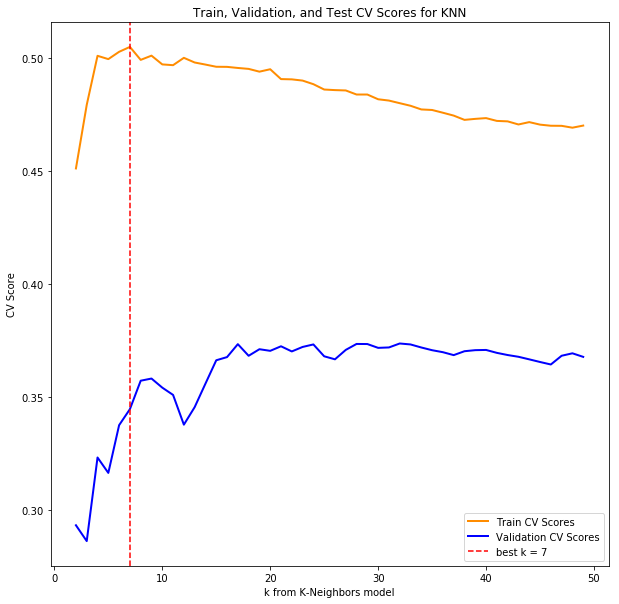

In [27]:
# Intersection of forward and backward selected subsets
intersection = list(set(predictors_forward).intersection(set(predictors_backward)))
inter_models = train_and_validate(X_tr, X_val, y_tr, y_val, intersection, "Intersection of BIC Selected Columns", add_const=True, poly=False)

### 3.7 Polynomial Features and Interaction Variables

In [28]:
# Model trained on the union of forward and backward subsets with polynomial and interaction variables
union = list(set(predictors_forward).union(set(predictors_backward)))
union_poly_models = train_and_validate(X_tr, X_val, y_tr, y_val, union,
                                       "Union of BIC Selected Columns with Polynomial Variables",
                                       add_const=True, poly=True, include_knn=False)

Training R^2 for Union of BIC Selected Columns with Polynomial Variables Linear Regression: 0.5925936931515721
Validation R^2 for Union of BIC Selected Columns with Polynomial Variables Linear Regression: -2.67272217648836



/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training R^2 for Union of BIC Selected Columns with Polynomial Variables Lasso Regression: 0.48592701270872163
Validation R^2 for Union of BIC Selected Columns with Polynomial Variables Lasso Regression: 0.42508113020444754

Training R^2 for Union of BIC Selected Columns with Polynomial Variables Ridge Regression: 0.49781968947957717
Validation R^2 for Union of BIC Selected Columns with Polynomial Variables Ridge Regression: 0.42074141255544384



/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [29]:
# Model trained on the intersection of forward and backward subsets with polynomial and interaction variables
intersection = list(set(predictors_forward).intersection(set(predictors_backward)))
inter_poly_models = train_and_validate(X_tr, X_val, y_tr, y_val, intersection,
                                       "Intersection of BIC Selected Columns with Polynomial Variables",
                                       add_const=True, poly=True, include_knn=False)

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training R^2 for Intersection of BIC Selected Columns with Polynomial Variables Linear Regression: 0.5925936931515721
Validation R^2 for Intersection of BIC Selected Columns with Polynomial Variables Linear Regression: -2.67272217648836

Training R^2 for Intersection of BIC Selected Columns with Polynomial Variables Lasso Regression: 0.48592701270872163
Validation R^2 for Intersection of BIC Selected Columns with Polynomial Variables Lasso Regression: 0.42508113020444754

Training R^2 for Intersection of BIC Selected Columns with Polynomial Variables Ridge Regression: 0.49781968947957717
Validation R^2 for Intersection of BIC Selected Columns with Polynomial Variables Ridge Regression: 0.42074141255544384



/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## 4 Model Trained with ATF Data

### 4.1 Retrieve ATF Data and merge DFs

In [30]:
def get_atf_vals(states, atf_df, recover=True):
    if len(states) > 1:
        state_counts = []
        for state in states:
            if recover:
                count = atf_df[atf_df["State"] == state]['Total Recovered'].values
            else:
                count = atf_df[atf_df["State"] == state]['Total Sourced'].values
            if len(count) > 0:
                state_counts.append(count[0])
        return np.mean(state_counts)
    else:
        if recover:
            return atf_df[atf_df["State"] == states[0]]['Total Recovered'].values[0]
        else:
            return atf_df[atf_df["State"] == states[0]]['Total Sourced'].values[0]

In [31]:
atf_filepaths = [f for f in listdir('atf_csvs') if isfile(join('atf_csvs', f))]

In [32]:
atf_dict = dict()
for file in atf_filepaths:
    df = pd.read_csv(join('atf_csvs', file))
    atf_dict[file[:4]] = df

In [33]:
df_dict = dict()
for i in range(0, 11):
    df_fbi = pd.read_csv(join('csvs/', csv_filepaths[i]))
    df_census = pd.read_csv(join(census_data_path, census_filepaths[i]), skiprows=1).drop(['Id', 'Id2'], axis=1)
    columns = [col for col in df_census.columns if 'Native' not in col and 'Margin of Error' not in col]
    foreign = [x for x in df_census.columns if 'born outside' in x][0]
    non_native = df_census[foreign]
    
    df_census = df_census[columns]
    df_census['non_native'] = non_native
    
    df = merge_df_msa(df_fbi, df_census)
    
    # Compute murders per 100,000 people
    population = [x for x in df.columns if 'Total population' in x][0]
    per_100 = pd.to_numeric(df[population], errors='coerce')/100000.0
    df['Murders_per_100000'] = df['Murder_and_nonnegligent_manslaughter']/per_100
    df['population'] = df[population]
    
    # Compute number of firearms recovered and sourced in each MSA state
    if str(i + 2006) in atf_dict.keys():
        atf_df = atf_dict[str(i + 2006)]
        msa = df['Metropolitan_Statistical_Area'].apply(lambda x: x.split(',')[1:][0].split())
        df['firearms_recovered'] = msa.apply(get_atf_vals, atf_df=atf_df, recover=True)
        df['firearms_sourced'] = msa.apply(get_atf_vals, atf_df=atf_df, recover=False)
    else:
        df['firearms_recovered'] = np.zeros(df.shape[0])        
        df['firearms_sourced'] = np.zeros(df.shape[0])
    
        # Drop any columns that don't have murder counts
    df = df.dropna(subset=['Murders_per_100000'])
    
    df_dict[i + 6] = df

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
frames = []
for k, v in df_dict.items():
    male = [x for x in v.columns if 'Male' in x][0]
    median_age = [x for x in v.columns if 'Median age' in x][0]
    median_income = [x for x in v.columns if 'Median income' in x][-1]
    black = [x for x in v.columns if 'Black or' in x][0]
    white = [x for x in v.columns if 'White' in x][0]
    hispanic = [x for x in v.columns if 'Hispanic' in x][0]
    poverty = [x for x in v.columns if 'poverty' in x][1]
    income_levels = [x for x in v.columns if 'Population 15 years and over - $' in x]
    income_labels = [x.split("- ")[-1] for x in v.columns if 'Population 15 years and over - $' in x]
    for i in range(0, len(income_levels)):
        v[income_labels[i]] = v[income_levels[i]]
    uneducated = [x for x in v.columns if 'EDUCATIONAL ATTAINMENT' in x][1]
    highschool = [x for x in v.columns if 'EDUCATIONAL ATTAINMENT' in x][2]
    college = [x for x in v.columns if 'EDUCATIONAL ATTAINMENT' in x][3:5]
    v["Year"] = 2000 + k
    non_native_series = pd.to_numeric(v['non_native'], errors='coerce').fillna(0)
    pop_series = pd.to_numeric(v['Total; Estimate; Total population'], errors='coerce').fillna(1)
    cols = ['Murder_and_nonnegligent_manslaughter', 'Murders_per_100000', 'Year', poverty, male,
            median_age, median_income, black, white, hispanic, uneducated, highschool] + income_levels
    df_temp = v[cols]
    column_labels = ['murder_count', 'murder_per_100000', 'year', 'poverty', 'male','median_age', 
                       'median_income', 'black', 'white', 'hispanic', 'uneducated', 'highschool'] + income_labels
    df_temp.columns = column_labels
    df_temp['college'] = v[college].sum(axis=1)
    df_temp['foreign'] = non_native_series / pop_series
    df_temp['population'] = v['population']
    df_temp[['firearms_sourced', 'firearms_recovered']] = v[['firearms_sourced', 'firearms_recovered']]
    frames.append(df_temp)
df_concat = pd.concat(frames)

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

### 4.2 OLS Model to determine statistical significance of additional ATF columns

In [35]:
y_atf = df_concat['murder_per_100000']
X_atf = df_concat.drop(['murder_per_100000', 'murder_count'], axis=1)
X_atf = X_atf.apply(pd.to_numeric, errors='coerce')
X_atf_train, X_atf_test, y_atf_train, y_atf_test = train_test_split(X_atf, y_atf, test_size=0.2, random_state=42)

In [36]:
X_tr, X_val, y_tr, y_val = train_test_split(X_atf_train, y_atf_train, test_size=0.2, random_state=42)

In [37]:
# Impute Nan values
imputer = Imputer(strategy='mean')
X_all_train = imputer.fit_transform(X_tr)
X_all_val = imputer.fit_transform(X_val)

# Scale everything and add constant
scaler = MinMaxScaler()
X_const_train = sm.add_constant(scaler.fit_transform(X_all_train))
X_const_val = sm.add_constant(scaler.fit_transform(X_all_val))

model = OLS(endog=y_tr, exog=X_const_train)
result = model.fit()

y_hat_train = result.predict()
y_hat_val = result.predict(exog=X_const_val)

print('Train R^2 =', r2_score(y_tr, y_hat_train))
print('Validation R^2 =', r2_score(y_val, y_hat_val))

Train R^2 = 0.447551488088
Validation R^2 = 0.409375635927


In [38]:
xlabs = ['const'] + list(X_tr.columns)
result.summary(xname=xlabs)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      murder_per_100000   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     73.09
Date:                Wed, 06 Dec 2017   Prob (F-statistic):          3.84e-247
Time:                        20:16:04   Log-Likelihood:                -4717.4
No. Observations:                2099   AIC:                             9483.
Df Residuals:                    2075   BIC:                             9618.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.0180      1.962      3.068      0.002       2.171       9.865
$1 to $9,999 or loss     0.6171      0.794      0.778      0.437      -0.939       2.174
$10,000 to $14,999       0.5167      0.596      0.867      0.386      -0.652       1.686
$15,000 to $24,999      -0.5391      0.906     -0.595      0.552      -2.316       1.238
$25,000 to $34,999       1.1126      0.616      1.806      0.071      -0.096       2.321
$35,000 to $49,999       0.5484      0.673      0.815      0.415      -0.771       1.868
$50,000 to $64,999      -1.0270      0.726     -1.415      0.157      -2.451       0.397
$65,000 to $74,999       1.1053      0.642      1.722      0.085      -0.154       2.364
$75,000 or more          1.7419      1.044      1.669      0.095      -0.305       3.788
black                    3.7867      0.491      7.715      0.000       2.824       4.749
college                  1.6117      0.868      1.856      0.064      -0.091       3.315
firearms_recovered       2.3063      1.162      1.984      0.047       0.027       4.586
firearms_sourced        -2.1071      0.963     -2.188      0.029      -3.995      -0.219
foreign                 -1.6875      0.472     -3.575      0.000      -2.613      -0.762
highschool               3.2509      0.783      4.150      0.000       1.715       4.787
hispanic                 0.8688      0.598      1.453      0.146      -0.304       2.042
male                    -0.6359      0.672     -0.946      0.344      -1.954       0.683
median_age               1.7402      0.707      2.460      0.014       0.353       3.127
median_income           -2.1822      1.188     -1.837      0.066      -4.512       0.148
population               1.7017      0.820      2.076      0.038       0.094       3.309
poverty                 -0.0787      0.708     -0.111      0.911      -1.467       1.309
uneducated               3.2177      0.917      3.508      0.000       1.419       5.016
white                   -8.8336      0.633    -13.955      0.000     -10.075      -7.592
year                     0.0035      0.207      0.017      0.987      -0.403       0.410
==============================================================================
Omnibus:                      514.015   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2296.064
Skew:                           1.105   Prob(JB):                         0.00
Kurtosis:                       7.623   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.3 Linear, Ridge, Lasso, and KNN Regressors trained on all columns including ATF

Training R^2 for All Columns Including ATF Linear Regression: 0.4462319942491597
Validation R^2 for All Columns Including ATF Linear Regression: 0.4108502357189554

Training R^2 for All Columns Including ATF Lasso Regression: 0.44560209039581394
Validation R^2 for All Columns Including ATF Lasso Regression: 0.4102549436785793

Training R^2 for All Columns Including ATF Ridge Regression: 0.4458059433121516
Validation R^2 for All Columns Including ATF Ridge Regression: 0.41016795215679747

Training Score for KNN (k=18) Model: 0.5069220726159709
Validation Score for KNN (k=18) Model: 0.44440789682622034


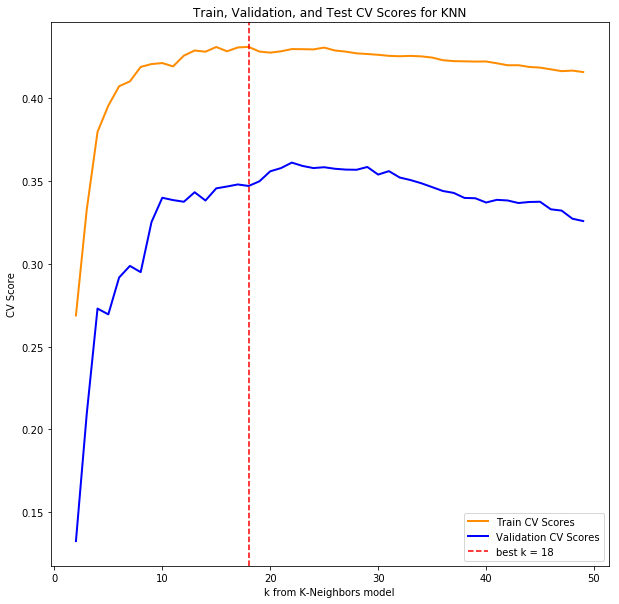

In [39]:
atf_all_model = train_and_validate(X_tr, X_val, y_tr, y_val, X.columns,
                                   "All Columns Including ATF", add_const=True, poly=False)

### 4.4 Models trained on most significant predictors determined by the OLS Model with ATF Columns

In [40]:
# Most significant predictors
most_significant_atf = np.array(xlabs)[np.array(result.pvalues < 0.05)][1:]
most_significant_atf

array(['black', 'firearms_recovered', 'firearms_sourced', 'foreign',
       'highschool', 'median_age', 'population', 'uneducated', 'white'], 
      dtype='<U20')

Training R^2 for Most Significant Columns as Determined by OLS Including ATF Linear Regression: 0.4416844727031795
Validation R^2 for Most Significant Columns as Determined by OLS Including ATF Linear Regression: 0.4055867039068164

Training R^2 for Most Significant Columns as Determined by OLS Including ATF Lasso Regression: 0.4416569916105543
Validation R^2 for Most Significant Columns as Determined by OLS Including ATF Lasso Regression: 0.405664008332985

Training R^2 for Most Significant Columns as Determined by OLS Including ATF Ridge Regression: 0.44144209747384194
Validation R^2 for Most Significant Columns as Determined by OLS Including ATF Ridge Regression: 0.4057770445145181

Training Score for KNN (k=20) Model: 0.5339733103141981
Validation Score for KNN (k=20) Model: 0.44500450313796264


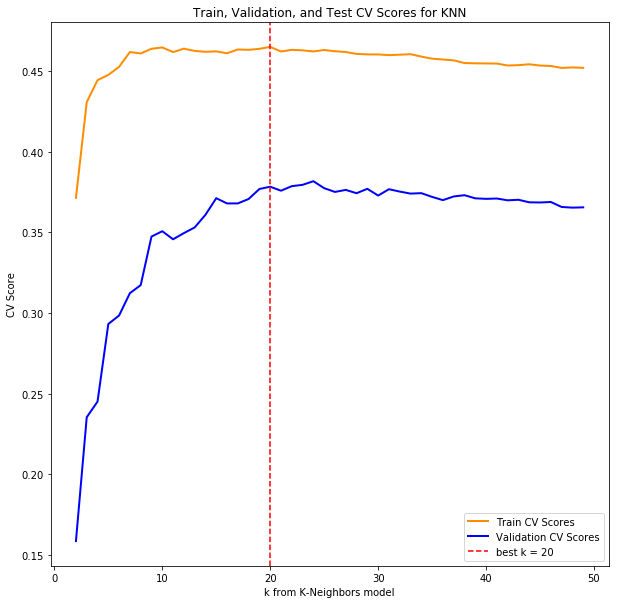

In [41]:
atf_most_significant = train_and_validate(X_tr, X_val, y_tr, y_val, most_significant_atf,
                                   "Most Significant Columns as Determined by OLS Including ATF",
                                    add_const=True, poly=False)

### 4.5 Models trained on most significant predictors with polynomial and interaction variables

Training R^2 for All Columns Including ATF with Polynomial Predictors Linear Regression: 0.7320519103314165
Validation R^2 for All Columns Including ATF with Polynomial Predictors Linear Regression: -304.9367042667425



/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training R^2 for All Columns Including ATF with Polynomial Predictors Lasso Regression: 0.49935261726706975
Validation R^2 for All Columns Including ATF with Polynomial Predictors Lasso Regression: 0.450994478817581

Training R^2 for All Columns Including ATF with Polynomial Predictors Ridge Regression: 0.5336746781783491
Validation R^2 for All Columns Including ATF with Polynomial Predictors Ridge Regression: 0.44413048096274194

Training Score for KNN (k=27) Model: 0.5172479091867096
Validation Score for KNN (k=27) Model: 0.4618831040144915


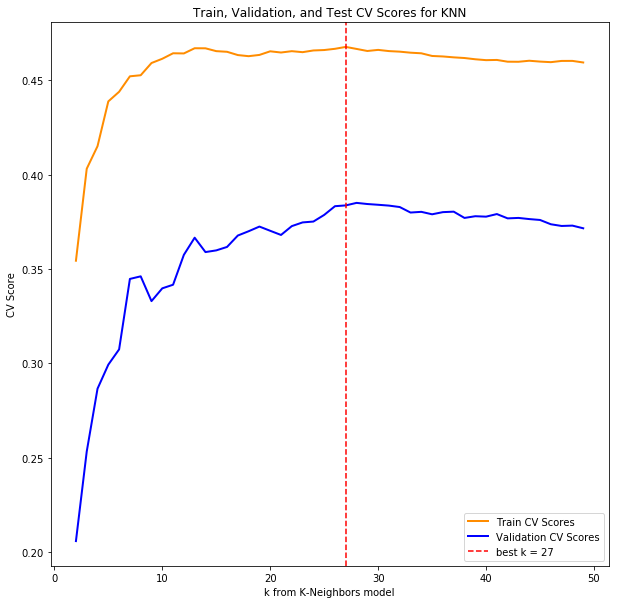

In [42]:
atf_most_sig_poly_model = train_and_validate(X_tr, X_val, y_tr, y_val, most_significant_atf,
                                   "All Columns Including ATF with Polynomial Predictors", add_const=True, poly=True)

### 4.6 Forwards and Backwards subset selection

In [43]:
# forwards selection with atf data
predictors_forward = step_forwards_backwards(X_tr, y_tr, direction='forward')
predictors_forward

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


['highschool', 'black', 'median_age', 'foreign', 'uneducated', 'white']

In [44]:
# backwards selection with atf data
predictors_backward = step_forwards_backwards(X_tr, y_tr, direction='backward')
predictors_backward

/Users/kazuma/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


['median_age', 'white', 'highschool', 'black', 'foreign', 'uneducated']

Forwards and backwards selection does not select atf data, and therefore we are not going to create a model using them

## 5 Testing the Final 2 models

### 5.1 Lasso Regression with ATF data, using predictors with p stat < 0.05 and polynomial features

In [45]:
X_lasso_atf_final = imputer.fit_transform(X_atf_test[most_significant_atf].values)

scaler = MinMaxScaler()

poly_generator = PolynomialFeatures(4, include_bias=False)
X_lasso_atf_final = scaler.fit_transform(X_lasso_atf_final)

X_lasso_atf_final = poly_generator.fit_transform(X_lasso_atf_final)

In [46]:
final_lasso_model = atf_most_sig_poly_model[1]

In [47]:
print("R^2 on the test set: {}".format(final_lasso_model.score(X_lasso_atf_final, y_atf_test)))

R^2 on the test set: 0.47946491031795335


### 5.2 KNN Regressor with forwards and backwards selected predictors

In [48]:
X_knn_atf_final = imputer.fit_transform(X_atf_test[intersection].values)

scaler = MinMaxScaler()
X_knn_atf_final = sm.add_constant(scaler.fit_transform(X_knn_atf_final))

In [49]:
final_knn_model = inter_models[3]

In [50]:
print("R^2 on the test set: {}".format(final_knn_model.score(X_knn_atf_final, y_atf_test)))

R^2 on the test set: 0.512266327944152
